(500, 2)


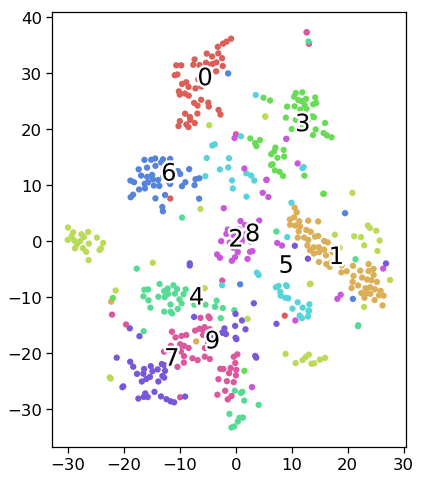

(?, 784)
(1,)


/home/pnatekar/anaconda3/envs/dl_torch/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/20
 - 4s - loss: 0.5013 - acc: 0.0000e+00
Epoch 2/20
 - 3s - loss: 0.5002 - acc: 0.0000e+00
Epoch 3/20
 - 3s - loss: 0.5002 - acc: 0.0000e+00
Epoch 4/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 5/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 6/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 7/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 8/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 9/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 10/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 11/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 12/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 13/20
 - 3s - loss: 0.5000 - acc: 0.0000e+00
Epoch 14/20
 - 3s - loss: 0.5000 - acc: 0.0000e+00
Epoch 15/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 16/20
 - 3s - loss: 0.5000 - acc: 0.0000e+00
Epoch 17/20
 - 3s - loss: 0.5001 - acc: 0.0000e+00
Epoch 18/20
 - 3s - loss: 0.5000 - acc: 0.0000e+00
Epoch 19/20
 - 3s - loss: 0.5000 - acc: 0.0000e+00
Epoch 20/20
 - 3s - loss: 0.5001 - acc: 

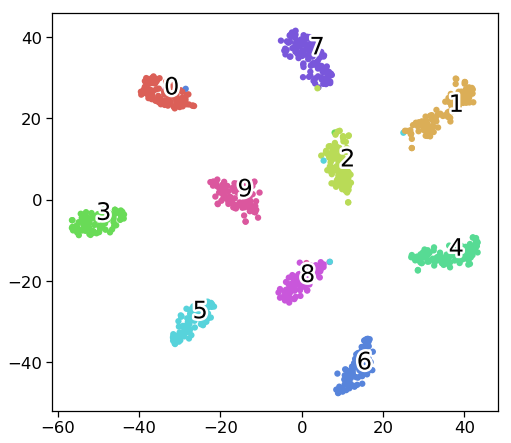

In [3]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.models import Model
from keras import regularizers, losses
from keras.regularizers import Regularizer
from keras import backend as K
from tqdm import tqdm
import os
from tensorflow_triplet_loss.model.triplet_loss import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
os.environ["CUDA_VISIBLE_DEVICES"]="0, 3"
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
from sklearn.preprocessing import MinMaxScaler
import pickle
import gzip
import sys
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_context('notebook', font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# load data


with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, test_set = pickle.load(f, encoding='latin1')
    
X_train,y_train = train_set

X_test,y_test = test_set

#from keras.datasets import fashion_mnist
#((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
# normalize inputs from 0-255 to 0-1
scaler = MinMaxScaler(feature_range = (-1,1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1

y_train_int = y_train
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    #ax.axis('off')
    #ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

X_embedded = TSNE(n_components=2).fit_transform(X_train[:500].reshape((-1, 784)))

print(X_embedded.shape)

scatter(X_embedded, np.argmax(y_train[:500], axis = 1))

def custom_loss(embeddings, m = 0.5):
    #embeddings = tf.nn.l2_normalize(embeddings, axis = 1)
    
    def faithfulness_loss(y_true, y_pred):
        
        
        loss = batch_hard_triplet_loss(y_true,embeddings,margin=m)
        #loss = K.expand_dims(loss, axis = -1)
        print(loss.get_shape())
        return(loss)
        
    return(faithfulness_loss)

#define main flow
main_input = Input(shape=(1,28,28))
conv1 = Conv2D(32, kernel_size=5, activation='relu', name = 'conv1', padding = 'same')(main_input)
conv2 = Conv2D(16, kernel_size=5, activation='relu', name = 'conv2', padding = 'same')(conv1)
conv4 = Conv2D(8, kernel_size=5, activation='relu', name = 'conv4', padding = 'same')(conv2)
x = Flatten(name = 'flatten')(conv4)
embedding = Dense(784, activation='relu', name = 'dense')(x)

print(embedding.shape)

#define baseline model
model = Model(inputs = main_input, output = embedding)
model.compile(loss=custom_loss(tf.nn.l2_normalize(embedding, axis = 1)), optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=300, verbose=2)

X_transformed = model.predict(X_train)

X_embedded_triplet = TSNE(n_components=2).fit_transform(X_transformed[:1000].reshape((-1, 784)))
                       
scatter(X_embedded_triplet, np.argmax(y_train[:1000], axis = 1))